# CS282r - Fall 2017 
## Improve Sepsis Treatment using Mixture of Experts
## Gating via Reinforcement Learning

Jerry, Yi, David

In [58]:
%matplotlib inline
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
MIN_INT_VALUE = -sys.maxsize - 1

import seaborn as sns; sns.set()
from collections import Counter

import restrictactions as ra
n_states = 750
n_actions = 25


## Load Data and Experts

In [2]:
# Baseline dataset
train_set = pd.read_csv('../../data/train_scaled_encoded.csv')
test_set = pd.read_csv('../../data/test_scaled_encoded.csv')

In [3]:
# Features used to drive expert selection
# => Obsolete
# train_input = pd.read_csv('../../data/train_input_features.csv')
# test_input = pd.read_csv('../../data/test_input_features.csv')
# test_input.columns

In [4]:
# Calculated state for each row in baseline
train_state_list = pkl.load(open('../../data/classify_state/train_states.pkl', 'rb'), encoding='latin1')
train_set['state'] = train_state_list
test_state_list = pkl.load(open('../../data/classify_state/test_states.pkl', 'rb'), encoding='latin1')
test_set['state'] = test_state_list

In [5]:
# Map actions to a single value in [0..24]
action_map = {}
count = 0
for iv in range(5):
    for vaso in range(5):
        action_map[(iv, vaso)] = count
        count += 1
        
def label_action(row):
    return action_map[(row['iv_input'],int(row['vaso_input']))]

train_set['phy_action'] = train_set.apply(lambda row: label_action(row),axis=1)
test_set['phy_action'] = test_set.apply(lambda row: label_action(row),axis=1)

In [6]:
# add in kernel policy
train_kernel_policy = pkl.load(open('../../data/train_kernel_policy_transformed.pkl', 'rb'), encoding='latin1')
train_set['krn_action'] = train_kernel_policy[:,3].astype(int)
test_kernel_policy = pkl.load(open('../../data/test_kernel_policy_transformed.pkl', 'rb'), encoding='latin1')
test_set['krn_action'] = test_kernel_policy[:,3].astype(int)

In [7]:
# add in DQN policy
train_dqn_policy = pd.DataFrame({'dqn_action':
                           pkl.load(open('../../data/dqn/train_agent_actions_2m.pkl', 'rb'), encoding='latin1')})
test_dqn_policy = pd.DataFrame({'dqn_action':
                           pkl.load(open('../../data/dqn/test_agent_actions_2m.pkl', 'rb'), encoding='latin1')})

train_set = pd.concat([train_set,train_dqn_policy],axis=1)
test_set = pd.concat([test_set,test_dqn_policy],axis=1)


### Simple Exploratory Data Analysis

In [8]:
# Get baseline mortality
episodes = test_set.groupby('icustayid')
n_died = 0
n_episodes = 0
for name, transitions in episodes:
    n_episodes += 1
    rewards = transitions['reward'].tolist()
    if rewards[-1] < 0:
        n_died += 1

print ("Testing Set Baseline mortality: {0:.1%}".format(n_died / n_episodes))

episodes = train_set.groupby('icustayid')
n_died = 0
n_episodes = 0
for name, transitions in episodes:
    n_episodes += 1
    rewards = transitions['reward'].tolist()
    if rewards[-1] < 0:
        n_died += 1

print ("Training Set Baseline mortality: {0:.1%}".format(n_died / n_episodes))
   

Testing Set Baseline mortality: 5.1%
Training Set Baseline mortality: 9.6%


In [9]:
test_set.head()

,0,1,2,3,4,5,6,7,8,9,...,198,199,vaso_input,iv_input,reward,icustayid,state,phy_action,krn_action,dqn_action
0,0.044787,0.024944,0.059501,0.186372,0.099174,0.010116,0.015910,0.031792,0.063170,0.050696,...,0.082892,0.012378,0,4.0,0.0,61.0,376,20,0,19
1,0.048257,0.029508,0.033046,0.102542,0.107019,0.015018,0.014971,0.034197,0.057205,0.072662,...,0.096143,0.013473,0,4.0,0.0,61.0,146,20,0,0
2,0.041906,0.028968,0.028705,0.111719,0.098205,0.013579,0.012648,0.027884,0.074506,0.081935,...,0.103266,0.015244,0,4.0,0.0,61.0,187,20,5,0
3,0.040383,0.029019,0.029167,0.131740,0.099840,0.013389,0.012455,0.028260,0.072425,0.088626,...,0.117384,0.015660,0,4.0,0.0,61.0,187,20,5,0
4,0.045685,0.029040,0.027817,0.137894,0.106901,0.013968,0.012697,0.028393,0.073113,0.088150,...,0.123431,0.014925,0,4.0,0.0,61.0,187,20,20,0


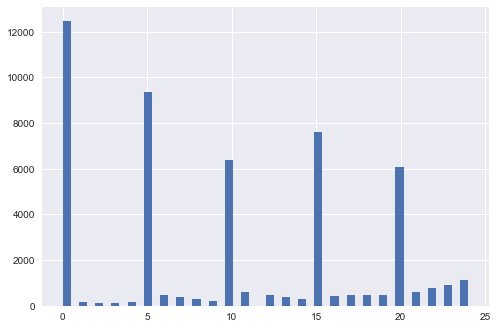

In [10]:
plt.hist(test_set['phy_action'],50)
pass

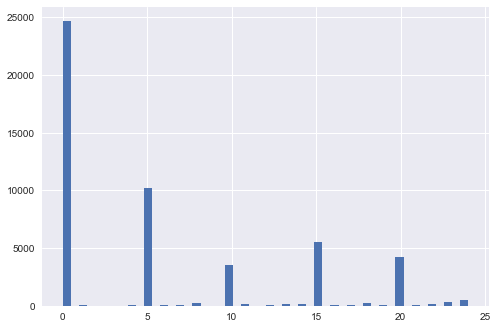

In [12]:
plt.hist(test_set['krn_action'],50)
pass

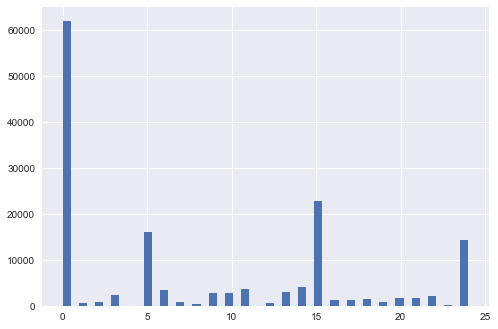

In [13]:
plt.hist(train_dqn_policy['dqn_action'],50)
pass

(array([ 5862.,  5685.,  5319.,  4449.,  6001.,  4816.,  5435.,  4140.,
         4657.,  4495.]),
 array([   0. ,   74.9,  149.8,  224.7,  299.6,  374.5,  449.4,  524.3,
         599.2,  674.1,  749. ]),
 <a list of 10 Patch objects>)

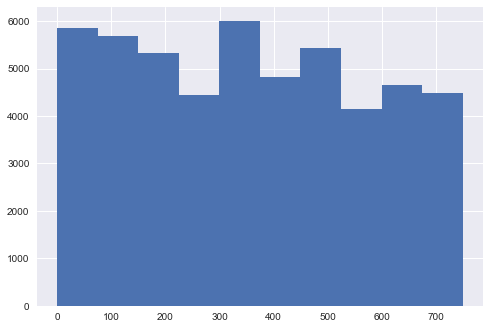

In [14]:
plt.hist(test_set['state'])

(array([ 17606.,  17926.,  16853.,  14000.,  16208.,  14909.,  15785.,
         11882.,  12994.,  12578.]),
 array([   0. ,   74.9,  149.8,  224.7,  299.6,  374.5,  449.4,  524.3,
         599.2,  674.1,  749. ]),
 <a list of 10 Patch objects>)

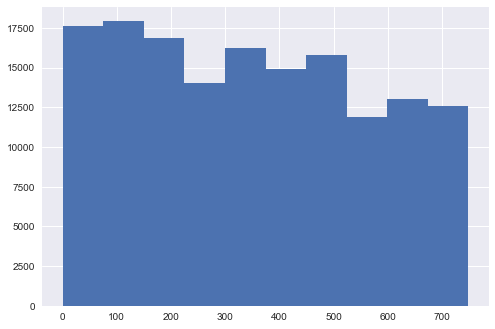

In [15]:
plt.hist(train_set['state'])

### Rewards and Terminal states

In [16]:
state_rewards = np.zeros((n_states))
state_reward_count = np.ones((n_states))
terminal_state = []

for name, transitions in episodes:
    states = transitions['state'].tolist()
    rewards = transitions['reward'].tolist()
    terminal_state.append(states[-1])
    state_rewards[states[-1]] += rewards[-1]
    state_reward_count[states[-1]] += 1

state_rewards = state_rewards / state_reward_count

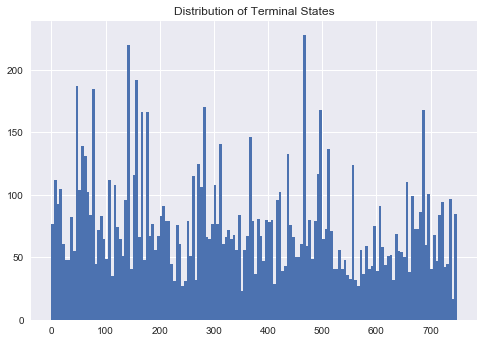

In [17]:
plt.hist(terminal_state,150)
plt.title("Distribution of Terminal States")
pass

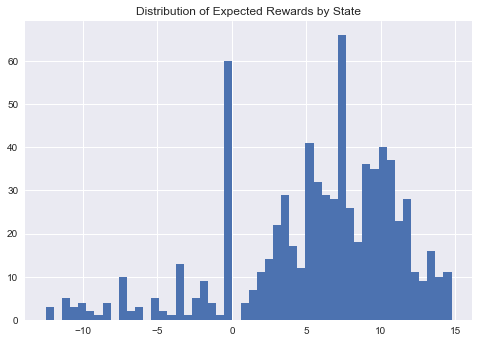

In [18]:
plt.hist(state_rewards,50)
plt.title("Distribution of Expected Rewards by State")
pass

Conclusion: there isn't a particular small set of states that are considered "terminal." However, some
terminal states have significantly more rewards than others. Choose the path that leads to the highest rewards.

### Populate Restricted Actions for Each Expert

In [19]:
#import importlib
#importlib.reload(ra)

In [66]:
# One for each expert
phy_ra = ra.RestrictActions(n_states,n_actions)
phy_ra.load_sas_as_episodes(episodes,'phy_action')

krn_ra = ra.RestrictActions(n_states,n_actions)
krn_ra.load_sas_as_episodes(episodes,'krn_action')

dqn_ra = ra.RestrictActions(n_states,n_actions)
dqn_ra.load_sas_as_episodes(episodes,'dqn_action')

experts = [phy_ra,krn_ra,dqn_ra]
expert_names = {phy_ra:'Physician',dqn_ra:'DQN',krn_ra:'Kernel'}

## Mixture of Experts Policy Selection Based on RL

Method:

* If there is physician consensus for a given action at a given state, simply choose it.
* If there is no consensus, walk the three action choices and pick the action that leads to
the state with the highest reward.

In [90]:
max_depth = 20
min_freq = 10
max_episodes = 100 # saving processing time to not report on all test episodes
stats_same_actions = np.zeros((len(experts),len(experts)))
stats_action_chosen = Counter()


In [34]:
def perform_phy_action(state,action):
    reward = state_rewards[state]
    state = int(np.max(phy_ra.sas_count[state,action]))
    return state, reward

In [91]:
def calc_different_actions(actions,experts):
    global stats_same_actions
    for expert_action in actions:
        for expert in experts:
            if actions[expert_action] == actions[expert]:
                stats_same_actions[experts.index(expert_action),experts.index(expert)] += 1


In [88]:
def perform_best_action(state,experts):
    global stats_action_chosen
    max_reward = MIN_INT_VALUE
    best_action = 0
    new_state = -1
    rewards = {expert: 0 for expert in experts}
    actions = {expert: -1 for expert in experts}
    
    for expert in experts:
        for a in expert.get_actions(state,min_freq=min_freq):
            for s in range(len(expert.sas_count[state][a])):
                if expert.sas_count[state][a][s] < min_freq:
                    continue
                if state_rewards[s] > rewards[expert]:
                    rewards[expert] = state_rewards[s]
                    actions[expert] = a
                    new_state = s
    
    max_reward = rewards[max(rewards,key=rewards.get)]
    best_action = actions[max(rewards,key=rewards.get)]
    calc_different_actions(actions,experts)
    stats_action_chosen[expert_names[max(rewards,key=rewards.get)]] += 1
    
    if new_state >= 0:
        return best_action, new_state, max_reward
    else:
        return None, None, None

In [53]:
def perform_best_action2(state,experts):
    global stats_dqn_chosen, stats_phy_chosen, stats_no_action, stats_different_actions
    global dqn_action_counts, phy_action_counts

    max_reward = MIN_INT_VALUE
    dqn_reward = MIN_INT_VALUE
    phy_reward = MIN_INT_VALUE
    best_action = 0
    new_state = -1
    phy_best_action = -1
    dqn_best_action = -1
    
    for a in phy_ra.get_actions(state,min_freq=min_freq):
        for s in range(len(phy_ra.sas_count[state][a])):
            if phy_ra.sas_count[state][a][s] < min_freq:
                continue
            if state_rewards[s] > phy_reward:
                phy_reward = state_rewards[s]
                phy_best_action = a
                best_action = a
                new_state = s
                
    for a in dqn_ra.get_actions(state,min_freq=min_freq):
        for s in range(len(dqn_ra.sas_count[state][a])):
            if dqn_ra.sas_count[state][a][s] < min_freq:
                continue
            if state_rewards[s] > dqn_reward:
                dqn_reward = state_rewards[s]
                dqn_best_action = a
                best_action = a
                new_state = s
    
    phy_action_counts[phy_best_action] += 1
    dqn_action_counts[dqn_best_action] += 1
    if phy_best_action != dqn_best_action:
        stats_different_actions += 1
        
    if phy_reward > dqn_reward:
        stats_phy_chosen += 1
        max_reward = phy_reward
    else:
        stats_dqn_chosen += 1
        max_reward = dqn_reward

    if new_state >= 0:
        #reward = state_rewards[new_state]
        return best_action, new_state, max_reward
    else:
        stats_no_action += 1
        return None, None, None

In [99]:
test_episodes = test_set.groupby('icustayid')

print ("|Physician Consensus | Mortality | Phy Consensus Occurred |")
print ("|:---|---|---:|")

for physician_consensus in [0.3,0.4,0.5,0.6,0.7]: 
    global dqn_action_counts, phy_action_counts
    n_died = 0
    n_episodes = 0
    actions_taken = 1 # avoid divide by zero
    stats_same_actions = np.zeros((len(experts),len(experts)))
    stats_action_chosen.clear()

    stats_phy_chosen = 0
    stats_dqn_chosen = 0
    stats_phy_consensus = 0
    stats_no_action = 0
    stats_different_actions = 0
    action_counts = np.zeros((n_actions))
    dqn_action_counts = np.zeros((n_actions))
    phy_action_counts = np.zeros((n_actions))

    for name, transitions in test_episodes:
        n_episodes += 1
        if n_episodes > max_episodes:
            break
        state = transitions['state'].tolist()[0]
        depth = 0 
        action_list = []
        state_list = []
        episode_reward = 0
        while True:
            if depth > max_depth:
                break
            depth += 1
            actions_taken += 1
            state = int(state)
            action = phy_ra.get_consensus(state,physician_consensus)
            if action is None:
                action, state, reward = perform_best_action(state,experts)
            else:
                state, reward = perform_phy_action(state,action)
                stats_phy_consensus += 1
            if reward is None:
                break
            elif reward < 0:
                n_died += 1
                break
            else:
                action_counts[action] +=1 
                episode_reward += reward
    print ("| {0:.0%} ".format(physician_consensus), end="")
    print ("| {0:.1%} ".format(n_died / n_episodes), end="")
    print ("| {0:.1%} |".format(stats_phy_consensus / actions_taken))
    sum(stats_action_chosen.values())
    print (dict(stats_action_chosen))
    print (stats_same_actions)


|Physician Consensus | Mortality | Phy Consensus Occurred |
|:---|---|---:|
| 30% | 7.9% | 7.5% |
{'Kernel': 408, 'Physician': 1200, 'DQN': 17}
[[ 1625.   556.   281.]
 [  556.  1625.   707.]
 [  281.   707.  1625.]]
| 40% | 5.9% | 4.9% |
{'Kernel': 424, 'Physician': 1329, 'DQN': 17}
[[ 1770.   806.   626.]
 [  806.  1770.  1056.]
 [  626.  1056.  1770.]]
| 50% | 5.9% | 3.0% |
{'Kernel': 277, 'Physician': 1517, 'DQN': 11}
[[ 1805.  1038.   857.]
 [ 1038.  1805.  1185.]
 [  857.  1185.  1805.]]
| 60% | 5.0% | 1.8% |
{'Kernel': 336, 'Physician': 1496, 'DQN': 14}
[[ 1846.  1016.   859.]
 [ 1016.  1846.  1159.]
 [  859.  1159.  1846.]]
| 70% | 0.0% | 0.6% |
{'Physician': 1562, 'Kernel': 352, 'DQN': 14}
[[ 1928.  1069.   944.]
 [ 1069.  1928.  1138.]
 [  944.  1138.  1928.]]


### Results 
|Physician Consensus | Mortality | Phy Consensus Occurred |
|:---|---|---:|
| 30% | 7.9% | 7.5% |
| 40% | 5.9% | 4.9% |
| 60% | 5.0% | 1.8% |
| 70% | 0.0% | 0.6% |


### Visualizations of Policies

In [103]:
s = 336 + 1496 + 14
print (336/ s)
print (1496 / s)
print (14/s)


0.1820151679306609
0.8104008667388949
0.007583965330444204


In [105]:
print (1016 / 1846)
print (859/1846)
print (1159/1846)

0.5503791982665223
0.46533044420368364
0.6278439869989165


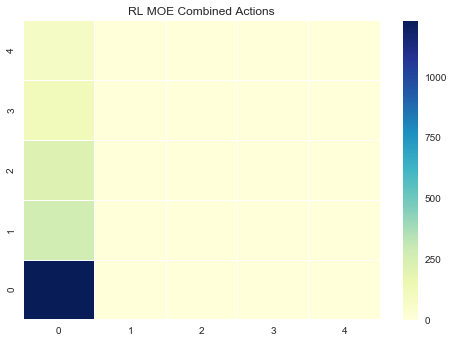

In [100]:
ax = sns.heatmap(action_counts.reshape(5,5), linewidths=.01, cmap="YlGnBu")
ax.invert_yaxis()
ax.set_title('RL MOE Combined Actions')

### Next Steps

Mortality on:
* DQN alone
* Kernel alone
* Logistic MOE
* RL MOE
* Mixed physician policy